# 代码笔记本


##   初始化
- `artist` 艺术家信息，以artist_id为索引
- `year` 年份信息，以年份为索引
- `music` 音乐信息
- `influence_network` 艺术家影响网络

### 设置样本数据路径


In [1]:
data_by_artist_src = "../problem/2021_ICM_Problem_D_Data/data_by_artist.csv"
data_by_year_src = "../problem/2021_ICM_Problem_D_Data/data_by_year.csv"
full_music_data_src = "../problem/2021_ICM_Problem_D_Data/full_music_data.csv"
influence_data_src = "../problem/2021_ICM_Problem_D_Data/influence_data.csv"


### 读入并整理数据


In [2]:
import pandas as pd

artist = pd.read_csv(data_by_artist_src).set_index(
    'artist_id', drop=False)
year = pd.read_csv(data_by_year_src).set_index('year', drop=False)
music = pd.read_csv(full_music_data_src)
influence_data = pd.read_csv(influence_data_src)

music['release_date'] = pd.to_datetime(
    music['release_date'], infer_datetime_format=True)
music['artists_id'] = music['artists_id'].apply(eval)
music['artist_names'] = music['artist_names'].apply(eval)

de = list()  # 保障数据完整性
for x in music.itertuples():
    for id in x.artists_id:
        if not id in artist.index:
            break
    else:
        continue
    de.append(x.Index)

music.drop(de, inplace=True)
del de


### 构建影响网络


In [3]:
import networkx as nx
influence_network = nx.DiGraph()
for x in influence_data.itertuples():
    influence_network.add_node(x.influencer_id, name=x.influencer_name,
                               main_genre=x.influencer_main_genre, active_start=x.influencer_active_start)
    influence_network.add_node(x.follower_id, name=x.follower_name,
                               main_genre=x.follower_main_genre, active_start=x.follower_active_start)
influence_network.add_edges_from([x for x in influence_data[[
                                 'influencer_id', 'follower_id']].itertuples(index=False, name=None)])

influence_network.remove_nodes_from(
    [node for node in influence_network.nodes if not node in artist.index])  # 保障数据完整性

del influence_data


## 环检测

In [4]:
def loop_check(id, visited=None):
    if visited is None:
        visited=set()
    if id in visited:
        print("检测到环！环上节点集合：", visited)
        return True
    visited.add(id)
    for next in influence_network[id]:
        if loop_check(next, visited.copy()):
            return True
    return False


for node in influence_network.nodes:
    if loop_check(node):
        break
else:
    print("未检测到环！")

del loop_check


检测到环！环上节点集合： {37730, 759491, 105129, 746302, 860561, 383889, 574102, 913210, 258430}


## 节点影响力计算
计算结果将保存至`influence_network.nodes[]['influence_coefficient']`中

In [5]:
_MAX_DEPTH = 4


def influence(id, visited=None, depth=0):
    if visited is None:
        visited=set()
    if id in visited or depth >= _MAX_DEPTH:
        return 0
    visited.add(id)
    ret = 1
    for jd in influence_network[id]:
        ret += influence(jd, visited.copy(), depth+1)*0.5
    return ret


for node in influence_network.nodes:
    influence_network.nodes[node]['influence_coefficient'] = influence(node)

del influence, _MAX_DEPTH


## 艺术家相似度计算
由于部分数据单位上差距过大，进行放缩处理

- `features` 音乐特征
- `artist_similarity[a][b]` a与b的相似度
- `artists_in_genre[genre]` 风格genre下艺术家列表
- `same_genre_similarity` 拥有*相同*音乐风格的艺术家普遍相似度
- `diff_genre_similarity` 拥有*不同*音乐风格的艺术家普遍相似度

In [6]:
from collections import defaultdict
features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'mode', 'key',
            'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'duration_ms', 'popularity']

artist_similarity = (artist[features]/artist[features].mean()).T.corr()

artists_in_genre = defaultdict(list)
nodes = list(influence_network.nodes)
for node in nodes:
    g = influence_network.nodes[node]['main_genre']
    artists_in_genre[g].append(node)

same_genre_similarity = 0
same_genre_cnt = 0

for genre in artists_in_genre:
    same_genre_similarity += artist_similarity[artists_in_genre[genre]
                                               ].T[artists_in_genre[genre]].sum().sum()-len(artists_in_genre[genre])
    same_genre_cnt += len(artists_in_genre[genre]
                          )**2-len(artists_in_genre[genre])

diff_genre_similarity = artist_similarity[nodes].T[nodes].sum(
).sum() - same_genre_similarity - len(nodes)
diff_genre_cnt = len(nodes)**2-len(nodes)-same_genre_cnt

same_genre_similarity /= same_genre_cnt
diff_genre_similarity /= diff_genre_cnt

del same_genre_cnt, diff_genre_cnt, nodes
print("same_genre_similarity=", same_genre_similarity)
print("diff_genre_similarity=", diff_genre_similarity)


same_genre_similarity= 0.1482310929092181
diff_genre_similarity= 0.007471663571085412


## 流派音乐风格相似度比较
- `genre_style[genre]` genre流派风格
- `genre_sim[a][b]` a、b间流派相似度

In [7]:
genre_style = pd.DataFrame(
    {genre: artist[features].T[artists_in_genre[genre]].T.mean() for genre in artists_in_genre})
genre_sim = (genre_style.T/genre_style.T.mean()).T.corr()
for genre in genre_sim.index:
    genre_sim[genre][genre] = 0
print("以下两个流派相似度最大：")
print(genre_sim.max().idxmax(), "<=>",
      genre_sim.idxmax()[genre_sim.max().idxmax()])
print("Similarity:", genre_sim.max().max())


以下两个流派相似度最大：
Avant-Garde <=> New Age
Similarity: 0.9654443550773767


## 流派间影响计算

未检测到环！
False


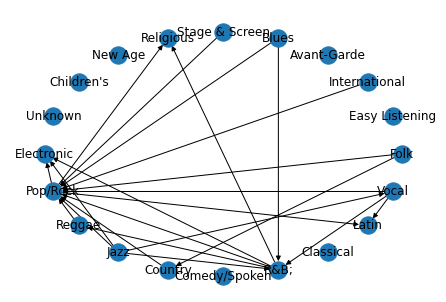

In [8]:
from pylab import show
genres = artists_in_genre.keys()
influence_in_genre = defaultdict(lambda: defaultdict(int))
for f, t in influence_network.edges:
    if influence_network.nodes[f]['main_genre'] != influence_network.nodes[t]['main_genre']:
        influence_in_genre[influence_network.nodes[f]['main_genre']
                           ][influence_network.nodes[t]['main_genre']] += 1

for a in genres:
    for b in genres:
        if b in influence_in_genre[a]:
            if a in influence_in_genre[b]:
                if influence_in_genre[a][b] > influence_in_genre[b][a]:
                    del influence_in_genre[b][a]
            if influence_in_genre[a][b] < 45:
                del influence_in_genre[a][b]

def loop_check(id, visited=None):
    if visited is None:
        visited=set()
    if id in visited:
        print("检测到环！环上节点集合：", visited)
        return True
    visited.add(id)
    for next in influence_in_genre[id]:
        if loop_check(next, visited.copy()):
            return True
    return False


for id in influence_in_genre:
    if loop_check(id):
        break
else:
    print("未检测到环！")


test = nx.DiGraph(influence_in_genre)
print(nx.is_weakly_connected(test))
nx.draw(test, pos=nx.shell_layout(test), with_labels=True)
show()


## 注：样本数据格式
- File: influence_data.csv
文件描述影响者与追随者的有向图关系。

|                      键 | 描述                                                                                                            |
| ----------------------: | :-------------------------------------------------------------------------------------------------------------- |
|           influencer_id | A unique identification number given to the person listed as influencer. (string of digits)                     |
|         influencer_name | The name of the influencing artist as given by the follower or industry experts. (string)                       |
|   influencer_main_genre | The genre that best describes the bulk of the music produced by the influencing artist. (if available) (string) |
| influencer_active_start | The decade that the influencing artist began their music career. (integer)                                      |
|             follower_id | A unique identification number given to the artist listed as follower. (string of digits)                       |
|           follower_name | The name of the artist following an influencing artist. (string)                                                |
|     follower_main_genre | The genre that best describes the bulk of the music produced by the following artist. (if available) (string)   |
|   follower_active_start | The decade that the following artist began their music career. (integer)                                        |
- File: data_by_artist.csv
文件描述作者信息及作曲风格。

|               键 | 描述                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ---------------: | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|      artist_name | The artist who performed the track. (array)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|        artist_id | The same unique identification number given in the influence_data.csv file. (string of digits)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|     danceability | A measure of how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. (float)                                                                                                                                                                                                                                                                                                                                                                |
|           energy | A measure representing a perception of intensity and activity. A value of 0.0 is least intense/energetic and 1.0 is most intense/energetic. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. (float)                                                                                                                                                                |
|          valence | A measure describing the musical positiveness conveyed by a track. A value of 0.0 is most negative and 1.0 is most positive. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). (float)                                                                                                                                                                                                                                                                                                       |
|            tempo | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. (float)                                                                                                                                                                                                                                                                                                                                                                                                        |
|         loudness | The overall loudness of a track in decibels (dB). Values typical range between -60 and 0 db. Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). (float)                                                                                                                                                                                                                                                                      |
|             mode | An indication of modality (major or minor), the type of scale from which its melodic content is derived, of a track. Major is represented by 1 and minor is 0.                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|              key | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value for key is -1. (integer)                                                                                                                                                                                                                                                                                                                                                                                                  |
|     acousticness | A confidence measure of whether the track is acoustic (without technology enhancements or electrical amplification). A value of 1.0 represents high confidence the track is acoustic. (float)                                                                                                                                                                                                                                                                                                                                                                                                             |
| instrumentalness | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. (float)                                                                                                                                                                                                |
|         liveness | Detects the presence of an audience in a track. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. (float)                                                                                                                                                                                                                                                                                                                                                                                 |
|      speechiness | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. (float)                                                                                            |
|      duration_ms | The duration of the track in milliseconds. (integer)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|       popularity | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played more frequently now will have a higher popularity than songs that were played more frequently in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity are derived mathematically from track popularity. (integer) |
|            count | The number of songs a particular artist is represented in the full_music_data.csv file. (integer)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
- File: data_by_year.csv
文件描述特定年份作曲潮流。

|               键 | 描述                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| ---------------: | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|             year | The year of release of a track. (integer from 1921 to 2020)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|     danceability | A measure of how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. (float)                                                                                                                                                                                                                                                                                                                                                                |
|           energy | A measure representing a perception of intensity and activity. A value of 0.0 is least intense/energetic and 1.0 is most intense/energetic. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. (float)                                                                                                                                                                |
|          valence | A measure describing the musical positiveness conveyed by a track. A value of 0.0 is most negative and 1.0 is most positive. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). (float)                                                                                                                                                                                                                                                                                                       |
|            tempo | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. (float)                                                                                                                                                                                                                                                                                                                                                                                                        |
|         loudness | The overall loudness of a track in decibels (dB). Values typical range between -60 and 0 db. Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). (float)                                                                                                                                                                                                                                                                      |
|             mode | An indication of modality (major or minor), the type of scale from which its melodic content is derived, of a track. Major is represented by 1 and minor is 0.                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|              key | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value for key is -1. (integer)                                                                                                                                                                                                                                                                                                                                                                                                  |
|     acousticness | A confidence measure of whether the track is acoustic (without technology enhancements or electrical amplification). A value of 1.0 represents high confidence the track is acoustic. (float)                                                                                                                                                                                                                                                                                                                                                                                                             |
| instrumentalness | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. (float)                                                                                                                                                                                                |
|         liveness | Detects the presence of an audience in a track. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. (float)                                                                                                                                                                                                                                                                                                                                                                                 |
|      speechiness | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. (float)                                                                                            |
|      duration_ms | The duration of the track in milliseconds. (integer)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|       popularity | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played more frequently now will have a higher popularity than songs that were played more frequently in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity are derived mathematically from track popularity. (integer) |
- File: full_music_data.csv
文件描述全部歌曲信息。

|                    键 | 描述                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| --------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|           artist_name | The artist who performed the track. (array)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|            artists_id | The same unique identification number given in the influence_data.csv file. (string of digits)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|          danceability | A measure of how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. (float)                                                                                                                                                                                                                                                                                                                                                                |
|                energy | A measure representing a perception of intensity and activity. A value of 0.0 is least intense/energetic and 1.0 is most intense/energetic. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. (float)                                                                                                                                                                |
|               valence | A measure describing the musical positiveness conveyed by a track. A value of 0.0 is most negative and 1.0 is most positive. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). (float)                                                                                                                                                                                                                                                                                                       |
|                 tempo | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. (float)                                                                                                                                                                                                                                                                                                                                                                                                        |
|              loudness | The overall loudness of a track in decibels (dB). Values typical range between -60 and 0 db. Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). (float)                                                                                                                                                                                                                                                                      |
|                  mode | An indication of modality (major or minor), the type of scale from which its melodic content is derived, of a track. Major is represented by 1 and minor is 0.                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|                   key | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value for key is -1. (integer)                                                                                                                                                                                                                                                                                                                                                                                                  |
|          acousticness | A confidence measure of whether the track is acoustic (without technology enhancements or electrical amplification). A value of 1.0 represents high confidence the track is acoustic. (float)                                                                                                                                                                                                                                                                                                                                                                                                             |
|      instrumentalness | Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. (float)                                                                                                                                                                                                |
|              liveness | Detects the presence of an audience in a track. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. (float)                                                                                                                                                                                                                                                                                                                                                                                 |
|           speechiness | Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. (float)                                                                                            |
|              explicit | Detects explicit lyrics in a track (true (1) = yes it does; false (0) = no it does not OR unknown). (Boolean)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
|           duration_ms | The duration of the track in milliseconds. (integer)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
|            popularity | The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played more frequently now will have a higher popularity than songs that were played more frequently in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity are derived mathematically from track popularity. (integer) |
|                  year | The year of release of a track. (integer from 1921 to 2020)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
|          release_date | The calendar date of release of a track mostly in yyyy-mm-dd format, however precision of date may vary and some just given as yyyy.                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| song_title (censored) | The name of the track. (string) Software was run to remove any potential explicit words in the song title.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |